1. CNN 사전학습 모델? 빅데이터를 통해 학습이 완료된 모델.

   1) AlexNet: 구조 간단. but, 과적합에 취약, 적은 특징 추출 횟수로도 가능.

   2) VGGNet: 필터 작아 세부 특징 검출 용이, 구조 간단. but, 레이어 구조가 깊어 기울기 소실 문제 취약, 모델 크기 크고 속도 느림.

   3) GoogLeNet(InceptionNet): 모델 가벼움, 학습 속도 빠름, 이미지에 효율적. but, 모델 구조 매우 어렵.
   
   4) ResNet (Residual Network): Skip Connection 구조로 기울기 소실 문제 해결. but, 구조 깊어 모델 무거움, cpu/램 소모 큼.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

In [2]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("CUDA(GPU)를 사용합니다.")

else:
  device = torch.device("cpu")
  print("CUDA(GPU)를 사용할 수 없으므로, CPU를 사용합니다.")

CUDA(GPU)를 사용합니다.


In [10]:
# myResNet 클래스 정의
class myResNet(nn.Module):
  def __init__(self):
    super(myResNet, self).__init__()
    # ResNet18 모델 로드
    self.resnet = models.resnet18(weights=None)
    # 출력 레이어를 클래스 수에 맞게 조정
    num_ftrs = self.resnet.fc.in_features
    self.resnet.fc = nn.Linear(num_ftrs, 10)

  def forward(self, x):
    return self.resnet(x)

In [88]:
# CIFAR10 데이터셋 로드 및 전처리
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.4913, 0.4821, 0.4465], [0.2470, 0.2434, 0.2615])
])

train_dataset = datasets.CIFAR10('./CIFAR10', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10('./CIFAR10', train=False, transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=250, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=250, shuffle=False)

Files already downloaded and verified


In [89]:
# 모델, 손실 함수, 최적화 알고리즘 설정
model = myResNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)

In [90]:
# 손실과 정확도를 저장하기 위한 리스트 초기화
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

In [91]:
# 훈련 함수
def train(model, train_loader, optimizer, epoch):
  model.train()
  train_loss = 0
  correct = 0
  total = 0
  for data, target in train_loader:
    if torch.cuda.is_available():
      data, target = data.to(device), target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    train_loss += loss.item()
    loss.backward()
    optimizer.step()

  # 예측값 계산(가장 높은 값을 가진 인덱스)
  _, predicted = torch.max(output.data, 1)
  total += target.size(0)
  # 올바르게 예측된 샘플의 수 업데이트
  correct += (predicted == target).sum().item()

  # 평균 훈련 손실 계산
  train_loss /= len(train_loader)
  train_losses.append(train_loss)
  print(f'Epoch {epoch}, Training loss: {train_loss:.4f}')
  accuracy =100. * correct / total
  train_accuracies.append(accuracy) # 정확도 기록을 위한 리스트에 추가

In [92]:
# 테스트 함수
def test(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      if torch.cuda.is_available():
        data, target = data.to(device), target.to(device)
      output = model(data)
      test_loss += criterion(output, target).item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader)
  accuracy = 100. * correct / len(test_loader.dataset)
  test_losses.append(test_loss)
  test_accuracies.append(accuracy)
  print(f'Test loss: {test_loss: .4f}. Accuracy: {accuracy: .2f}%')

---
Adam, lr =0.01, batch_size = 250, 250

optimizer에 weight_decay=1e-4 추가

In [93]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 1.7776
Test loss:  1.5717. Accuracy:  43.98%
Epoch 2, Training loss: 1.2895
Test loss:  1.3711. Accuracy:  51.89%
Epoch 3, Training loss: 1.0422
Test loss:  1.0254. Accuracy:  64.18%
Epoch 4, Training loss: 0.8941
Test loss:  0.9365. Accuracy:  67.02%
Epoch 5, Training loss: 0.8190
Test loss:  1.0402. Accuracy:  65.06%
Epoch 6, Training loss: 0.7719
Test loss:  0.9027. Accuracy:  68.34%
Epoch 7, Training loss: 0.7191
Test loss:  0.8944. Accuracy:  69.48%
Epoch 8, Training loss: 0.6895
Test loss:  0.9112. Accuracy:  70.42%
Epoch 9, Training loss: 0.6664
Test loss:  0.7976. Accuracy:  72.89%
Epoch 10, Training loss: 0.6329
Test loss:  0.9122. Accuracy:  69.83%
Epoch 11, Training loss: 0.6190
Test loss:  0.8248. Accuracy:  72.37%
Epoch 12, Training loss: 0.5949
Test loss:  0.8479. Accuracy:  71.97%
Epoch 13, Training loss: 0.5829
Test loss:  0.7983. Accuracy:  73.20%
Epoch 14, Training loss: 0.5603
Test loss:  0.8178. Accuracy:  72.72%
Early stopping at epoch 14


---
SGD, lr =0.01, batch_size = 1000, 1000

optimizer에 weight_decay=1e-4 추가

In [86]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 2.0296
Test loss:  1.8119. Accuracy:  34.43%
Epoch 2, Training loss: 1.6746
Test loss:  1.6285. Accuracy:  40.38%
Epoch 3, Training loss: 1.5152
Test loss:  1.5219. Accuracy:  44.08%
Epoch 4, Training loss: 1.4081
Test loss:  1.4572. Accuracy:  46.92%
Epoch 5, Training loss: 1.3273
Test loss:  1.4191. Accuracy:  48.38%
Epoch 6, Training loss: 1.2543
Test loss:  1.3981. Accuracy:  50.04%
Epoch 7, Training loss: 1.1971
Test loss:  1.3927. Accuracy:  50.12%
Epoch 8, Training loss: 1.1378
Test loss:  1.3601. Accuracy:  51.17%
Epoch 9, Training loss: 1.0787
Test loss:  1.3509. Accuracy:  51.63%
Epoch 10, Training loss: 1.0251
Test loss:  1.3472. Accuracy:  52.79%
Epoch 11, Training loss: 0.9706
Test loss:  1.3392. Accuracy:  52.61%
Epoch 12, Training loss: 0.9195
Test loss:  1.3336. Accuracy:  53.34%
Epoch 13, Training loss: 0.8597
Test loss:  1.3489. Accuracy:  53.30%
Epoch 14, Training loss: 0.8100
Test loss:  1.3588. Accuracy:  52.69%
Epoch 15, Training loss: 0.76

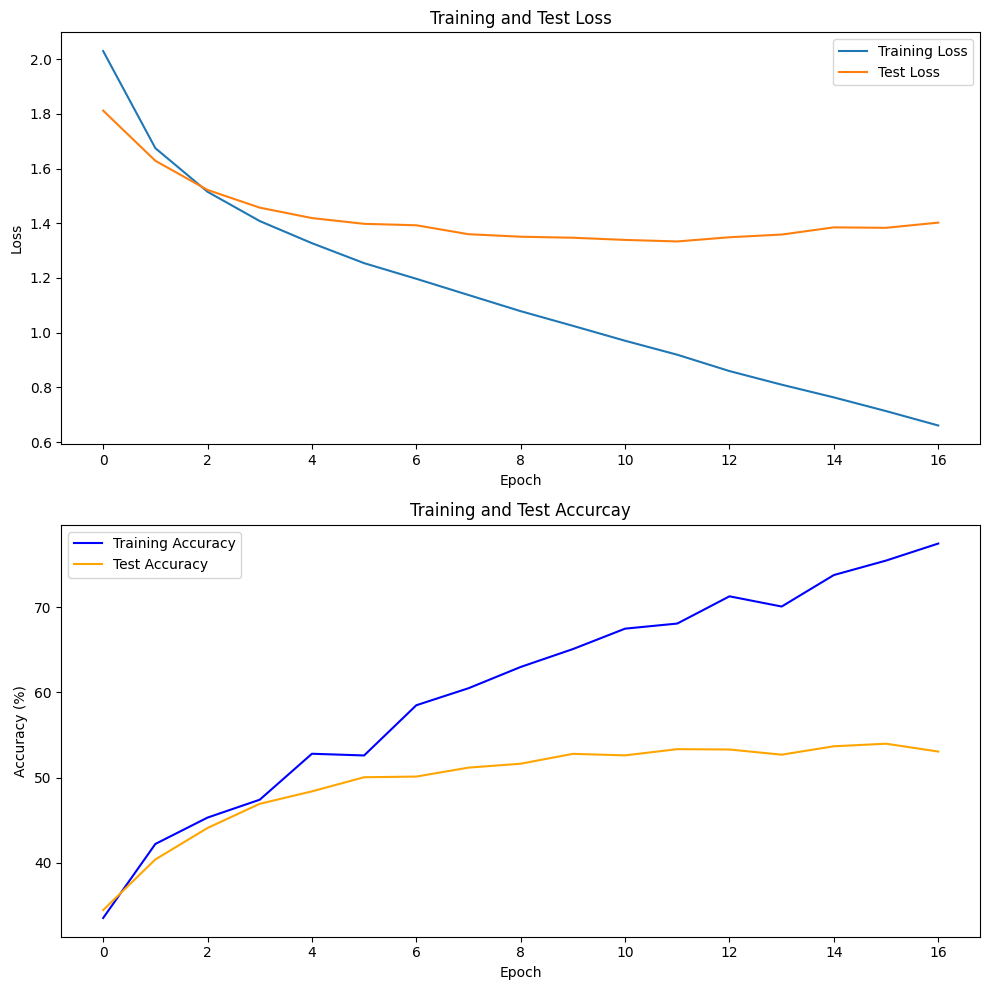

In [87]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr =0.01, batch_size = 1000, 1000

optimizer에 weight_decay=1e-4 추가

In [79]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 2.0418
Test loss:  1.6292. Accuracy:  40.03%
Epoch 2, Training loss: 1.4802
Test loss:  1.4191. Accuracy:  48.01%
Epoch 3, Training loss: 1.2325
Test loss:  1.3618. Accuracy:  51.20%
Epoch 4, Training loss: 1.0396
Test loss:  1.3600. Accuracy:  60.06%
Epoch 5, Training loss: 0.9351
Test loss:  1.1702. Accuracy:  58.99%
Epoch 6, Training loss: 0.8128
Test loss:  1.0190. Accuracy:  64.75%
Epoch 7, Training loss: 0.7266
Test loss:  0.9636. Accuracy:  67.98%
Epoch 8, Training loss: 0.6509
Test loss:  0.9040. Accuracy:  69.58%
Epoch 9, Training loss: 0.5877
Test loss:  0.8424. Accuracy:  71.07%
Epoch 10, Training loss: 0.5278
Test loss:  0.9207. Accuracy:  69.49%
Epoch 11, Training loss: 0.4800
Test loss:  0.8700. Accuracy:  71.87%
Epoch 12, Training loss: 0.4317
Test loss:  0.9414. Accuracy:  70.22%
Epoch 13, Training loss: 0.4028
Test loss:  0.9057. Accuracy:  71.41%
Epoch 14, Training loss: 0.3710
Test loss:  0.9107. Accuracy:  71.16%
Early stopping at epoch 14


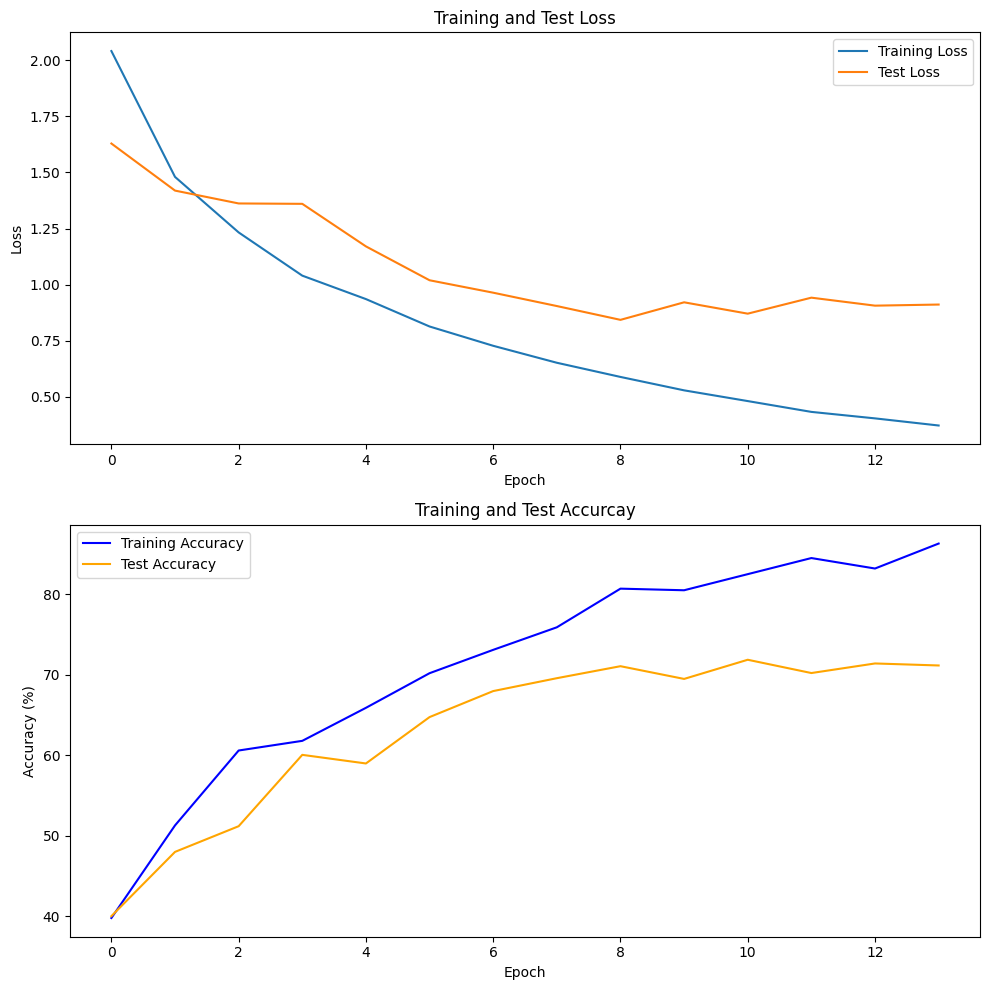

In [80]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr =0.01, batch_size = 400, 800

optimizer에 weight_decay=1e-4 추가

In [66]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 1.8254
Test loss:  1.7030. Accuracy:  37.13%
Epoch 2, Training loss: 1.3321
Test loss:  1.2647. Accuracy:  54.72%
Epoch 3, Training loss: 1.0796
Test loss:  1.0390. Accuracy:  64.03%
Epoch 4, Training loss: 0.9381
Test loss:  0.9468. Accuracy:  67.13%
Epoch 5, Training loss: 0.8113
Test loss:  0.8740. Accuracy:  70.58%
Epoch 6, Training loss: 0.7356
Test loss:  0.8930. Accuracy:  69.37%
Epoch 7, Training loss: 0.6826
Test loss:  0.8805. Accuracy:  70.31%
Epoch 8, Training loss: 0.6358
Test loss:  0.8438. Accuracy:  71.75%
Epoch 9, Training loss: 0.5915
Test loss:  0.8726. Accuracy:  71.41%
Epoch 10, Training loss: 0.5726
Test loss:  0.8417. Accuracy:  72.42%
Epoch 11, Training loss: 0.5362
Test loss:  0.7955. Accuracy:  73.25%
Epoch 12, Training loss: 0.5175
Test loss:  0.8109. Accuracy:  73.41%
Epoch 13, Training loss: 0.4930
Test loss:  0.8203. Accuracy:  72.84%
Epoch 14, Training loss: 0.4743
Test loss:  0.8250. Accuracy:  73.02%
Epoch 15, Training loss: 0.46

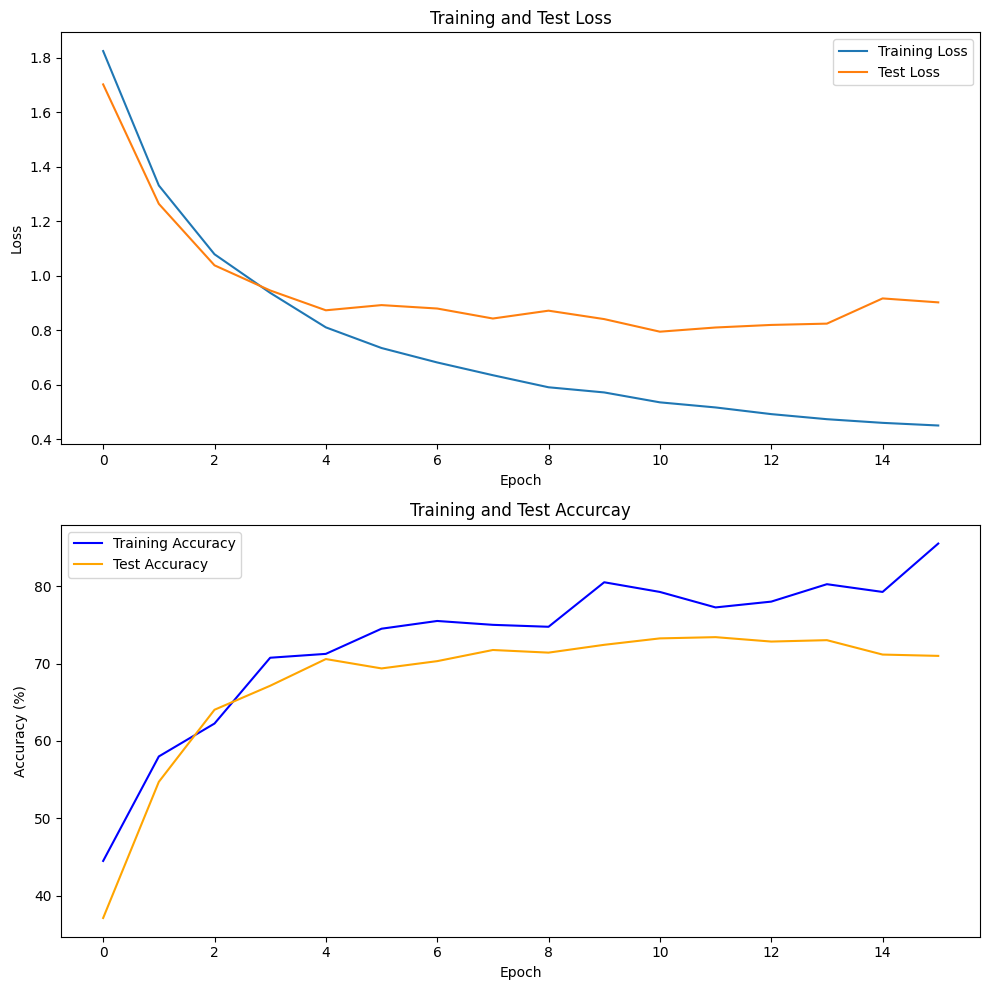

In [67]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr =0.01, batch_size = 500, 500

In [55]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 1.8027
Test loss:  1.4682. Accuracy:  45.75%
Epoch 2, Training loss: 1.3713
Test loss:  1.2658. Accuracy:  54.33%
Epoch 3, Training loss: 1.0727
Test loss:  1.0257. Accuracy:  63.07%
Epoch 4, Training loss: 0.9087
Test loss:  0.9220. Accuracy:  68.31%
Epoch 5, Training loss: 0.7633
Test loss:  0.8852. Accuracy:  69.40%
Epoch 6, Training loss: 0.6545
Test loss:  0.8168. Accuracy:  72.15%
Epoch 7, Training loss: 0.7015
Test loss:  0.8206. Accuracy:  72.64%
Epoch 8, Training loss: 0.5056
Test loss:  0.8429. Accuracy:  72.99%
Epoch 9, Training loss: 0.4133
Test loss:  0.8547. Accuracy:  73.10%
Epoch 10, Training loss: 0.3373
Test loss:  0.8618. Accuracy:  74.31%
Epoch 11, Training loss: 0.2707
Test loss:  0.9560. Accuracy:  73.26%
Early stopping at epoch 11


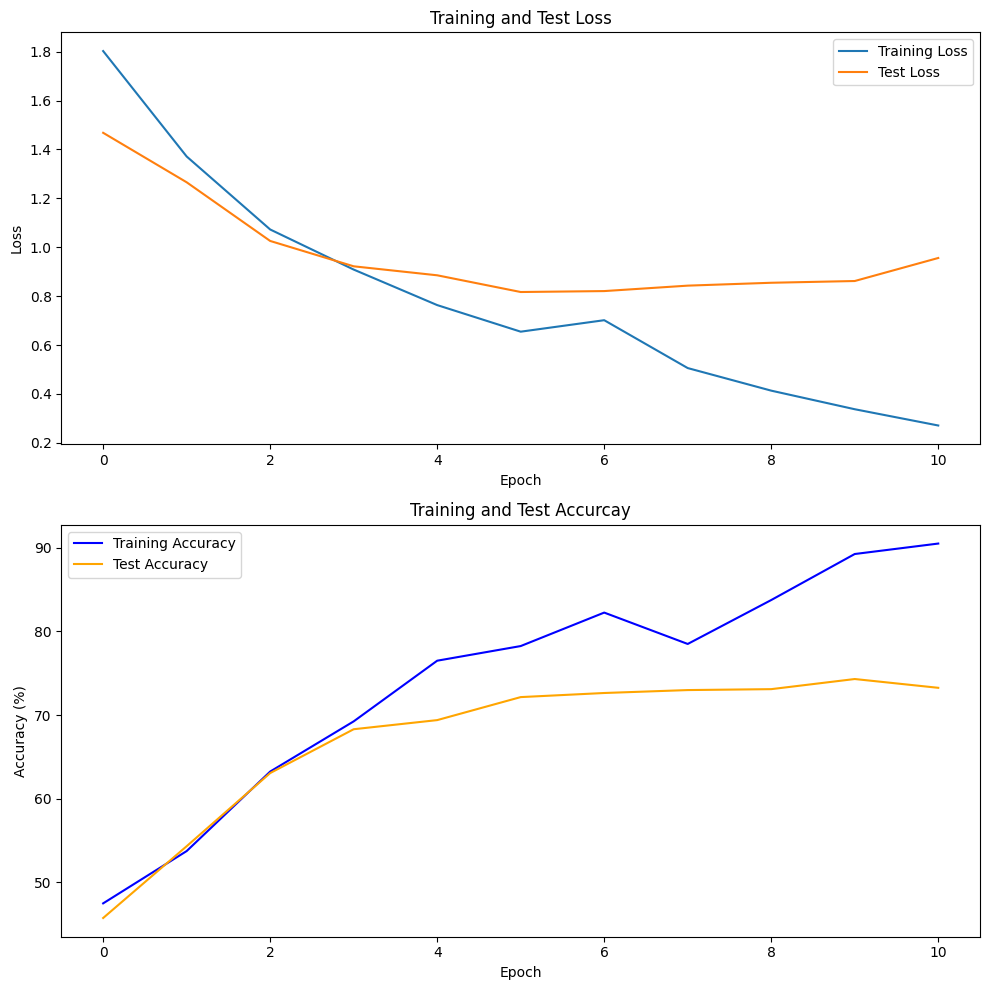

In [56]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr =0.01, batch_size = 500, 1000

In [47]:
# epoch=50 실행. 실행 동안 test_loss가 5번 이상 개선되지 않을 때 조기 종료됨.
best_loss = float('inf')
no_improvement = 0
patience = 5

for epoch in range(1, 50):
    train(model, train_loader, optimizer, epoch)
    test(model, test_loader)

    # 검증 손실 계산
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item()
        test_loss /= len(test_loader)

        # 최저 검증 손실 업데이트 및 조기 종료 체크
        if test_loss < best_loss:
            best_loss = test_loss
            no_improvement = 0
            # 모델 저장
            torch.save(model.state_dict(), 'best_model.pt')
        else:
            no_improvement += 1
            if no_improvement >= patience:
                print(f'Early stopping at epoch {epoch}')
                break


Epoch 1, Training loss: 1.8197
Test loss:  1.4787. Accuracy:  45.63%
Epoch 2, Training loss: 1.3668
Test loss:  1.3487. Accuracy:  52.09%
Epoch 3, Training loss: 1.0933
Test loss:  1.0903. Accuracy:  60.77%
Epoch 4, Training loss: 0.9182
Test loss:  2.5366. Accuracy:  56.87%
Epoch 5, Training loss: 0.8011
Test loss:  0.8815. Accuracy:  69.60%
Epoch 6, Training loss: 0.6684
Test loss:  0.9173. Accuracy:  69.48%
Epoch 7, Training loss: 0.5763
Test loss:  0.8217. Accuracy:  72.58%
Epoch 8, Training loss: 0.4851
Test loss:  0.8355. Accuracy:  73.38%
Epoch 9, Training loss: 0.3866
Test loss:  0.9116. Accuracy:  72.84%
Epoch 10, Training loss: 0.3286
Test loss:  0.8626. Accuracy:  74.17%
Epoch 11, Training loss: 0.2486
Test loss:  0.9560. Accuracy:  73.05%
Epoch 12, Training loss: 0.1955
Test loss:  1.0515. Accuracy:  73.73%
Early stopping at epoch 12


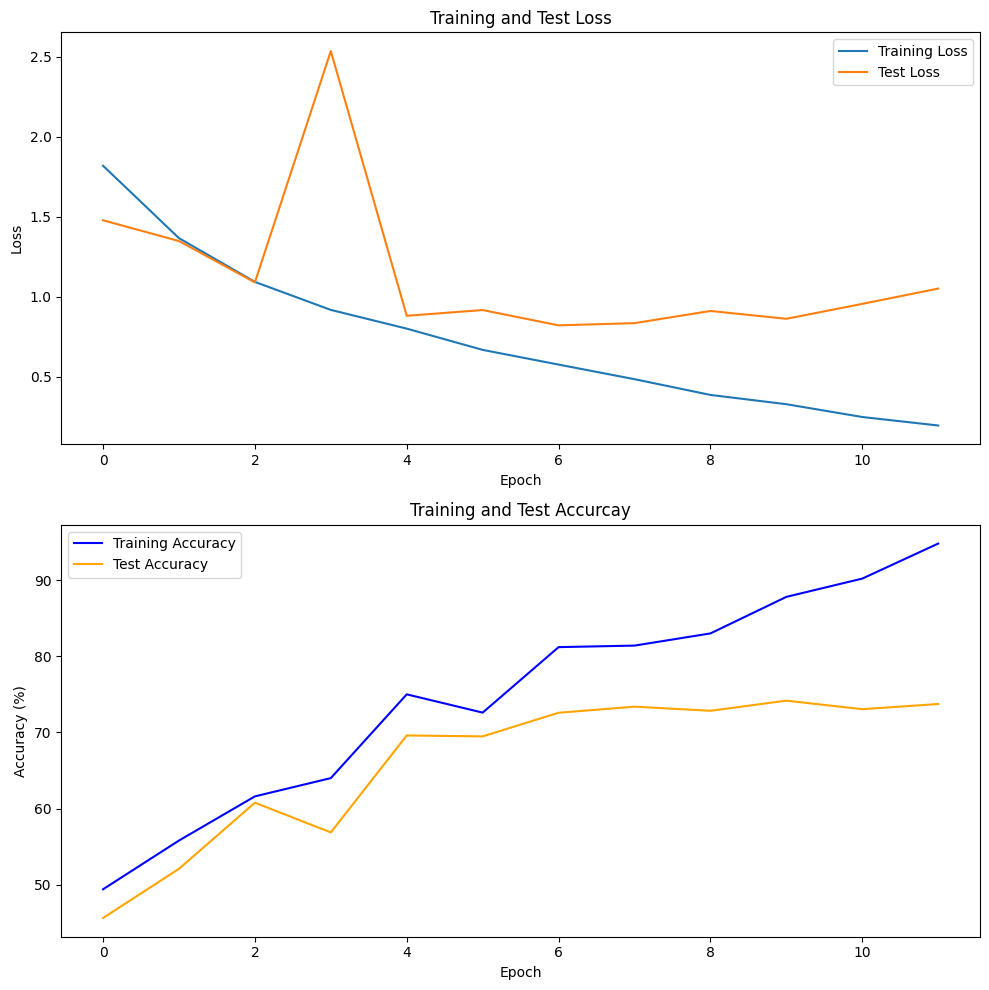

In [48]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr =0.01, batch_size = 400, 800

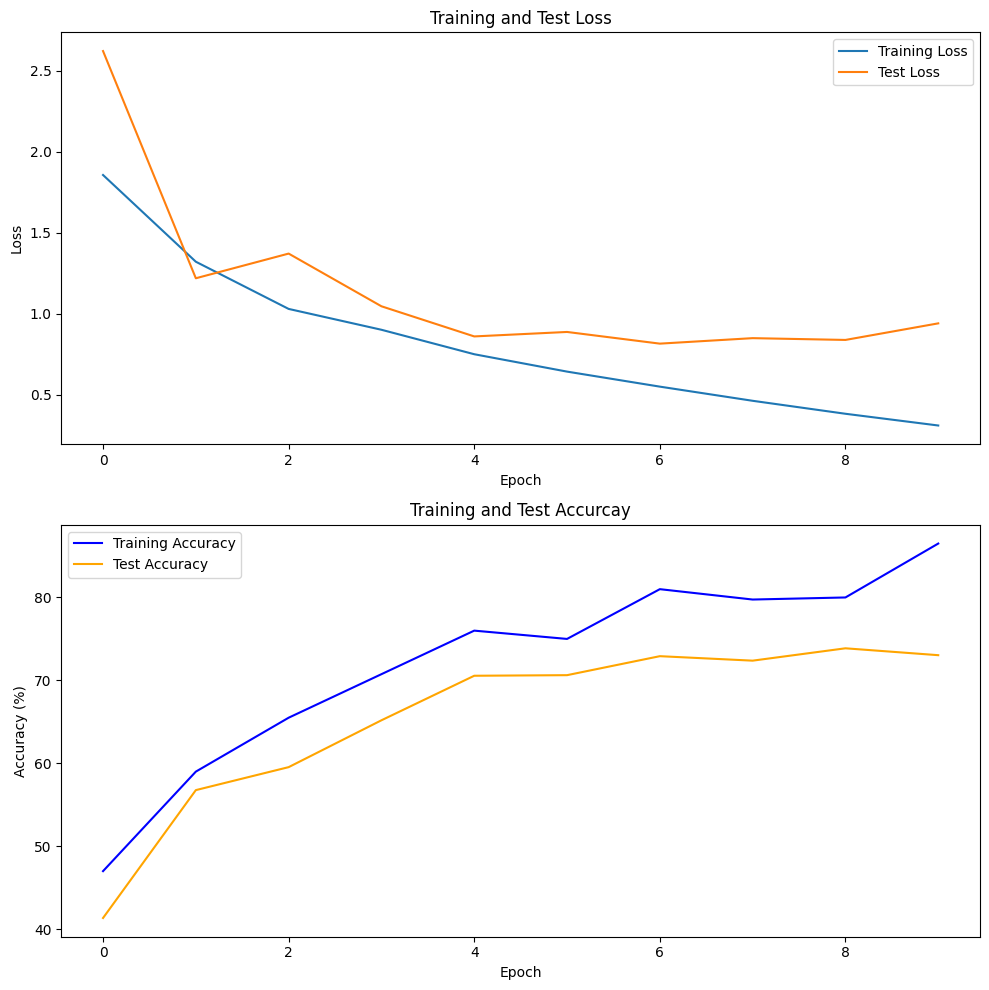

In [18]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()

---
Adam, lr = 0.001, batch_size = 400, 800

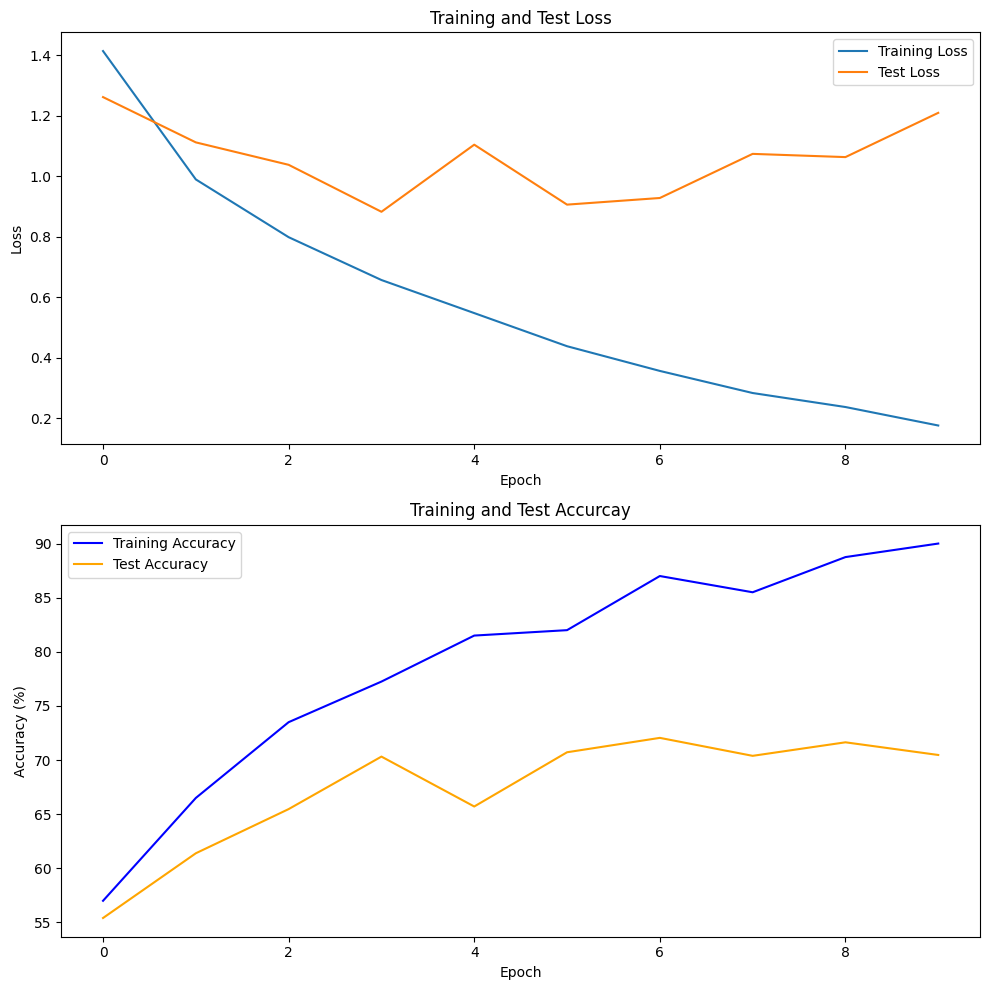

In [24]:
import matplotlib.pyplot as plt

# 손실 및 정확도 시각화
fig, axs = plt.subplots(2, 1, figsize=(10, 10))

axs[0].plot(train_losses, label = 'Training Loss')
axs[0].plot(test_losses, label = 'Test Loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].legend()
axs[0].set_title('Training and Test Loss')

axs[1].plot(train_accuracies, label='Training Accuracy', color = 'blue')
axs[1].plot(test_accuracies, label='Test Accuracy', color='orange')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy (%)')
axs[1].legend()
axs[1].set_title('Training and Test Accurcay')

plt.tight_layout()
plt.show()